In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

Using TensorFlow backend.


## Data Preprocessing

In [2]:
# Data Preprocessing
missing_values = ['Nan', 'n/a', '--']
data = pd.read_csv('Loan_data_part_I.csv', na_values = missing_values)
#data.isnull().values.any()
data['loan_status'][data['loan_status'] == 'Fail'] = 0
data['loan_status'][data['loan_status'] == 'Current'] = 1
data = data.drop('id', axis = 1)
data = data.astype('int')
#data.describe()
#data

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# Splitting the dataset into
X = data.drop('loan_status', axis = 1)
y = data['loan_status']

# Applying Random Undersampling with replacement
#rus = RandomUnderSampler(random_state = 69, replacement = True)
#X, y = rus.fit_sample(X, y)

# Applying Random Oversampling with replacement
ros = RandomOverSampler(random_state = 69)
X, y = ros.fit_sample(X, y)

# Applying Random Oversampling with replacement
#ross = SMOTE(random_state = 69)
#X, y = ross.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 69)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, shuffle = True, random_state = 69)

In [4]:
# Standardising the data
#sc_x = StandardScaler()
#X_train = sc_x.fit_transform(X_train)
#X_val = sc_x.transform(X_val)
#X_test = sc_x.transform(X_test)

In [5]:
# Normalising the data (min max)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators = 1000, criterion = 'gini', 
                              min_samples_split = 40, min_samples_leaf = 10, random_state = 69)

In [ ]:
# Grid Search for hyperparameters optimization
criterion = ['gini', 'entropy']
n_estimators = [500, 1000]
min_samples_split = [20, 25, 30, 35, 40]
min_samples_leaf = [1, 3, 5, 7, 10]

param_grid = dict(min_samples_split = min_samples_split, n_estimators = n_estimators, 
                  criterion = criterion, min_samples_leaf = min_samples_leaf)

cv = KFold(n_splits = 5, shuffle = True, random_state = 69)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

In [ ]:
clf.fit(X_train, y_train)

### Results Validation Set

In [6]:
RF_fpr, RF_tpr, _ = roc_curve(y_val, clf.predict_proba(X_val)[:,1])
RF_roc_auc = auc(RF_fpr, RF_tpr)
accuracy = accuracy_score(y_val, clf.predict(X_val))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(RF_roc_auc, accuracy))

NameError: name 'clf' is not defined

In [ ]:
# Plotting the graph
plt.plot(RF_fpr, RF_tpr, 'b', label = 'AUC = %0.3f' % RF_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Results Test Set

In [ ]:
RF_test_fpr, RF_test_tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
RF_test_roc_auc = auc(RF_test_fpr, RF_test_tpr)
accuracy = accuracy_score(y_test, clf.predict(X_test))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(RF_test_roc_auc, accuracy))

In [ ]:
# Plotting the graph
plt.plot(RF_test_fpr, RF_test_tpr, 'b', label = 'AUC = %0.3f' % RF_test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# Confusion matrix
cf_RF = confusion_matrix(y_test, clf.predict(X_test))
#fig_RF = plt.figure(figsize = (4,3))
#plt.title('Random Forest - Confusion Matirx')
#ax = fig_RF.gca()
#sn.heatmap(cf_RF, annot=True)
cf_RF

## Neural Networks

In [ ]:
# Hyperparameters to be optimzed

#lr = [0.1, 0.01, 0.001]
#optimizer = ['adam', 'SGD', 'RMSprop']
kernel_initializer = ['normal', 'uniform']
batch_size = [15, 30, 60]
#epochs = [100, 150, 200]
#activation = ['relu', 'elu', 'tanh']

In [7]:
def build_classifier():#optimizer = optimizer, lr = lr, kernel_initializer = kernel_initializer):
    # Initialising the ANN
    classifier = Sequential()
    # Adding the input layer and the first hidden layer
    classifier.add(Dense(units = 20, kernel_initializer = 'normal', activation = 'relu', input_dim = 46))
    # Adding dropout for NN training
    classifier.add(Dropout(0.6))
    # Adding the second hidden layer
    classifier.add(Dense(units = 7, kernel_initializer = 'normal', activation = 'relu'))
    # Adding dropout for NN training
    classifier.add(Dropout(0.6))
    # Adding the third hidden layer
    classifier.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
    # Adding the output layer
    classifier.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'sigmoid'))
    # Compiling the ANN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

In [8]:
classifier = KerasClassifier(build_fn = build_classifier)

In [9]:
classifier.fit(X_train, y_train, batch_size = 30, 
               epochs = 300, callbacks = [EarlyStopping(monitor = 'loss', patience = 5)])

Epoch 1/300
71968/71968 [==============================] - 6s 79us/step - loss: 0.6665 - accuracy: 0.6044
Epoch 2/300
71968/71968 [==============================] - 5s 67us/step - loss: 0.6561 - accuracy: 0.6206
Epoch 3/300
71968/71968 [==============================] - 5s 67us/step - loss: 0.6538 - accuracy: 0.6204
Epoch 4/300
71968/71968 [==============================] - 5s 68us/step - loss: 0.6526 - accuracy: 0.6195
Epoch 5/300
71968/71968 [==============================] - 5s 69us/step - loss: 0.6519 - accuracy: 0.6206
Epoch 6/300
71968/71968 [==============================] - 5s 70us/step - loss: 0.6511 - accuracy: 0.6214
Epoch 7/300
71968/71968 [==============================] - 5s 71us/step - loss: 0.6504 - accuracy: 0.6213
Epoch 8/300
71968/71968 [==============================] - 5s 71us/step - loss: 0.6500 - accuracy: 0.6231
Epoch 9/300
71968/71968 [==============================] - 5s 72us/step - loss: 0.6499 - accuracy: 0.6205
Epoch 10/300
71968/71968 [====================

In [ ]:
# Grid Search for hyperparameters optimization

param_grid = dict(kernel_initializer = kernel_initializer, batch_size = batch_size)#optimizer = optimizer, epochs = epochs

cv = KFold(n_splits = 5, shuffle = True, random_state = 69)
grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, scoring = 'accuracy', cv = cv, n_jobs = -1)
grid_search = grid_search.fit(X = X_train, y = y_train)

# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

### Results Validation Set

In [10]:
NN_fpr, NN_tpr, _ = roc_curve(y_val, classifier.predict_proba(X_val)[:,1])
NN_roc_auc = auc(NN_fpr, NN_tpr)
accuracy = accuracy_score(y_val, classifier.predict(X_val))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(NN_roc_auc, accuracy))

The roc auc in the test set is 0.715 and the accuracy is 0.65


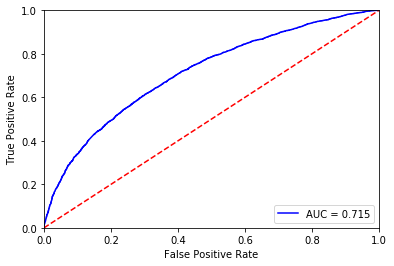

In [11]:
# Plotting the graph
plt.plot(NN_fpr, NN_tpr, 'b', label = 'AUC = %0.3f' % NN_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Results Test Set

In [12]:
NN_test_fpr, NN_test_tpr, _ = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
NN_test_roc_auc = auc(NN_test_fpr, NN_test_tpr)
accuracy = accuracy_score(y_test, classifier.predict(X_test))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(NN_test_roc_auc, accuracy))

The roc auc in the test set is 0.708 and the accuracy is 0.65


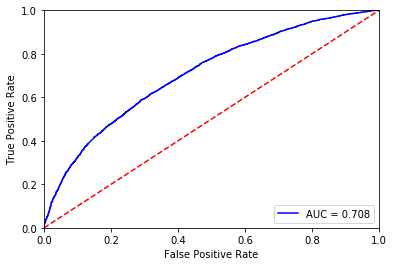

In [13]:
# Plotting the graph
plt.plot(NN_test_fpr, NN_test_tpr, 'b', label = 'AUC = %0.3f' % NN_test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
# Confusion matrix
cf_NN = confusion_matrix(y_test, classifier.predict(X_test))
#fig_NN = plt.figure(figsize = (7,5))
#plt.title('Neural Networks - Confusion Matirx')
#ax = fig_NN.gca()
#sn.heatmap(cf_NN, annot=True)
cf_NN

array([[5197, 2617],
       [2825, 4783]])

## Out of Sample

In [15]:
# Data Preprocessing
missing_values = ['Nan', 'n/a', '--']
df = pd.read_csv('Loan_data_part_II.csv', na_values = missing_values)
#df.isnull().values.any()
df['loan_status'][df['loan_status'] == 'Fail'] = 0
df['loan_status'][df['loan_status'] == 'Current'] = 1
df = df.drop('id', axis = 1)
df = df.astype('int')
#df.describe()
#df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Splitting the dataset into
X = df.drop('loan_status', axis = 1)
y = df['loan_status']

In [17]:
# Standardising the data
#sc_x_oos = StandardScaler()
#X = sc_x_oos.fit_transform(X)

In [18]:
# Normalising the data (min max)
scaler_oos = MinMaxScaler()
scaler_oos.fit(X)
X = scaler.transform(X)

## Random Forest Out of Sample

In [ ]:
RF_oos_fpr, RF_oos_tpr, _ = roc_curve(y, clf.predict_proba(X)[:,1])
RF_oos_roc_auc = auc(RF_oos_fpr, RF_oos_tpr)
accuracy = accuracy_score(y, clf.predict(X))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(RF_oos_roc_auc, accuracy))

In [ ]:
# Plotting the graph
plt.plot(RF_oos_fpr, RF_oos_tpr, 'b', label = 'AUC = %0.3f' % RF_oos_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network Out of Sample

In [19]:
NN_oos_fpr, NN_oos_tpr, _ = roc_curve(y, classifier.predict_proba(X)[:,1])
NN_oos_roc_auc = auc(NN_oos_fpr, NN_oos_tpr)
accuracy = accuracy_score(y, classifier.predict(X))
print("The roc auc in the test set is %0.3f and the accuracy is %0.2f"
      %(NN_oos_roc_auc, accuracy))

The roc auc in the test set is 0.714 and the accuracy is 0.65


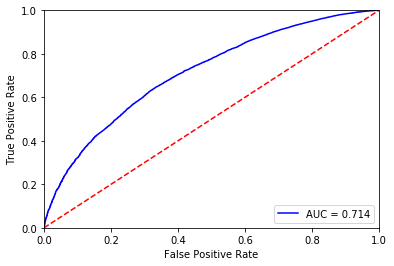

In [20]:
# Plotting the graph
plt.plot(NN_oos_fpr, NN_oos_tpr, 'b', label = 'AUC = %0.3f' % NN_oos_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()